In [1]:
import os
import PyPDF2
import fitz
import pandas as pd

In [2]:
from nltk import tokenize
# import nltk
# nltk.download('punkt')

In [3]:
dir = 'annoted_sustainability_reports/Real_Estate'

### Extracting Sentences

In [4]:
# aggregated sentences per report
highlighted_num = []
highlighted_sentences = [] 
all_sentences = []
highlighted_label = []
all_label = []

# aggregated sentences of the entire industry (tokenizing highlighted_result & all_result)
rel_text = []
rel_label = []
all_text_final = []

x_label = ["AmericanTowerCorp", "Prologis", "CrownCastle"]

for file in os.listdir(dir): # running all the files in the industry folder
    f = os.path.join(dir, file) # joining filename and directory
    print(f)
    
    # labelling sentences by companies 
    res = list(filter(lambda x:  x in f, x_label))

    doc = fitz.open(f) # opening each company report
    print(doc)
    
    # results of each report
    highlighted_result = []
    all_result = [] 
    
    # Iterate each page of the document 
    for page in doc:
        
        # extract all the sentences in pdf 
        test = page.get_text()
        all_result.append(test)
        
        # extracting highlighted sentences from pdf 
        highlights = []
        annot = page.first_annot
        
        while annot:
            if annot.type[0] == 8:
                all_coordinates = annot.vertices
                try:
                    if len(all_coordinates) == 4:
                        highlight_coord = fitz.Quad(all_coordinates).rect
                        highlights.append(highlight_coord)
                    else:
                        all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                        for i in range(0,len(all_coordinates)):
                            coord = fitz.Quad(all_coordinates[i]).rect
                            highlights.append(coord)
                except:
                    print("NoneType found")
            annot = annot.next
        
        # calculate coordinate sum to eliminate duplicated sentences 
        coordinate_sum_total = []
        all_words = page.get_text_words()
        highlight_text = []
        if len(highlights) > 0:
            for h in highlights:
                sentence = []
                num_i = 0
                for w in all_words:
                    if (fitz.Rect(w[0:4]).intersects(h)):
                        if str(sum(w[0:4])) not in coordinate_sum_total: #if no duplicate coordinate sum found, append
                            coordinate_sum_total.append(str(sum(w[0:4])))
                            sentence.append(w[4])
            
                highlight_text.append(" ".join(sentence))
        
#         print(highlight_text)
        
        if len(highlight_text) > 0:
            highlighted_result.append(" ".join(highlight_text))
        
#         print(result)

    # Results of the entire industry & keeps track of number of sentences in highlighted_num
    highlighted_num.append(len(highlighted_result))
    highlighted_sentences.append(highlighted_result)
    all_sentences.append(all_result)
    
    print(len(highlighted_result))
    
#         print(test_text)
        
    for r in highlighted_result:
        if r is not None:
            # tokenize sentences by pages where the sentences is found 
            # instead of conducting it to the entire report this enhances accuracy 
            rel_text += tokenize.sent_tokenize(r)
            highlighted_label.append(res)
            rel_label += res * len(tokenize.sent_tokenize(r))         
    
    for i in all_result:
        all_text_final += tokenize.sent_tokenize(i.replace("\n", " "))
        all_label += res * len(tokenize.sent_tokenize(i.replace("\n", " ")))
        
#     print(highlighted_sentences, "\n", len(highlighted_sentences))



annoted_sustainability_reports/Real_Estate/AmericanTowerCorp_2021_Sustainability_report.pdf
Document('annoted_sustainability_reports/Real_Estate/AmericanTowerCorp_2021_Sustainability_report.pdf')
5
annoted_sustainability_reports/Real_Estate/Prologis_21to22_ESG_report.pdf
Document('annoted_sustainability_reports/Real_Estate/Prologis_21to22_ESG_report.pdf')
6
annoted_sustainability_reports/Real_Estate/CrownCastle_2021_ESG_report.pdf
Document('annoted_sustainability_reports/Real_Estate/CrownCastle_2021_ESG_report.pdf')
2


In [5]:
highlighted_num

[5, 6, 2]

In [6]:
rel_text_df = pd.DataFrame([rel_text, rel_label]).transpose()
rel_text_df = rel_text_df.rename(columns = {0: 'relevant_sentences', 1: 'company_label'})
rel_text_df.head()

,relevant_sentences,company_label
0,American Tower is targeting a 40% reduction in...,AmericanTowerCorp
1,American Tower is targeting a 40% reduction in...,AmericanTowerCorp
2,"In 2021, our scope 1 emissions decreased 6.5% ...",AmericanTowerCorp
3,Our overall scope 1 and 2 emissions reduction ...,AmericanTowerCorp
4,"At 99% of the approximately 1,000 newly built ...",AmericanTowerCorp


In [7]:
all_text_final_df = pd.DataFrame([all_text_final, all_label]).transpose()
all_text_final_df = all_text_final_df.rename(columns = {0: 'all_sentences', 1: 'company_label'})
all_text_final_df.head()

,all_sentences,company_label
0,2021 Sustainability Report,AmericanTowerCorp
1,Table of Contents 3 About American Tower 5 Le...,AmericanTowerCorp
2,"About American Tower Founded in 1995, American...",AmericanTowerCorp
3,"With a presence in 25 countries, we are a lea...",AmericanTowerCorp
4,We lease space on our communications sites to...,AmericanTowerCorp


### Getting Sentence Statistics 

In [8]:
# count rel sentences 
rel_count = rel_text_df.groupby('company_label', sort = False).count()

# count all sentences
sent_count = all_text_final_df.groupby('company_label', sort = False).count()

In [9]:
sentences_list = []
rel_sent_list = []

final_text_stat = pd.concat([sent_count, rel_count],  sort = False, axis = 1)

[rel_sent_list.append(rel_sent) for rel_sent in final_text_stat['relevant_sentences']]    
[sentences_list.append(all_sent) for all_sent in final_text_stat['all_sentences']]    
    
final_text_stat['relevant_sentences'] = final_text_stat['relevant_sentences'].fillna(0)
final_text_stat['percentages'] = final_text_stat['relevant_sentences'] / final_text_stat['all_sentences'] * 100
final_text_stat

,all_sentences,relevant_sentences,percentages
company_label,,,
AmericanTowerCorp,1210,15,1.239669
Prologis,896,26,2.901786
CrownCastle,146,4,2.739726


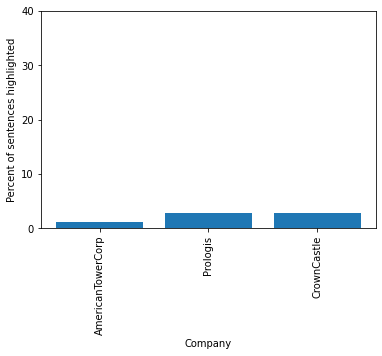

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import glob
y = []

x = ["AmericanTowerCorp", "Prologis", "CrownCastle"]

i = 0

for file in os.listdir(dir):
    y.append(100 * (rel_sent_list[i])/sentences_list[i])
    i = i+1

plt.bar(x, y, width = 0.8)
plt.xticks(rotation='vertical')
plt.xlabel("Company")
plt.ylabel("Percent of sentences highlighted")
plt.yticks(np.arange(0, 50, 10))
plt.show()

In [11]:
import pandas as pd

series = pd.Series(y)
series.describe()

count    3.000000
mean     2.293727
std      0.916430
min      1.239669
25%      1.989698
50%      2.739726
75%      2.820756
max      2.901786
dtype: float64

### Exporting and Saving Files 

In [12]:
#storing variable so they can be called between notebooks (for aggregate analysis, test/train data sets, and modeling later on)

Real_Estate_reltext = rel_text_df
Real_Estate_alltext = all_text_final_df
Real_Estate_stat = final_text_stat

%store Real_Estate_reltext
%store Real_Estate_alltext
%store Real_Estate_stat

Stored 'Real_Estate_reltext' (DataFrame)
Stored 'Real_Estate_alltext' (DataFrame)
Stored 'Real_Estate_stat' (DataFrame)
